In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from utils.nets import *
from utils.model_tools import *

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Constants

LEARNING_RATE = 0.001
EXP_DECAY = 0.0001

batch_size = 4

# Files
CIFAR10_model_file = "./logs/cifar_10_cnn.pt"
#VGG11_model_file = "./logs/vgg11.pt"
#VGG19_model_file = "./logs/vgg19.pt"

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
# Loading general CIFAR10 trainsets/testsets
CIFAR10_train_gen = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
CIFAR10_trainloader_gen = torch.utils.data.DataLoader(CIFAR10_train_gen, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

CIFAR10_test_gen = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
CIFAR10_testloader_gen = torch.utils.data.DataLoader(CIFAR10_test_gen, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

CIFAR10_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# In the paper, the classes left out are 'cat' and 'car'; 'cat' is added back in later

#CIFAR10_cnn = CIFAR10Cnn(8)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Filtering classes from CIFAR10

# Creates dataloader without cat and car (indices 1 and 3) classes
no_cat_car_idx = np.where((np.array(CIFAR10_train_gen.targets) != 1) & (np.array(CIFAR10_train_gen.targets) != 3))[0]
no_cat_car_subset = torch.utils.data.Subset(CIFAR10_train_gen, no_cat_car_idx)
no_cat_car_dl = torch.utils.data.DataLoader(no_cat_car_subset, batch_size=batch_size, shuffle=True, num_workers=2)

# Dataloader for everything but car
no_car_idx = np.where((np.array(CIFAR10_train_gen.targets) != 1))[0]
no_car_subset = torch.utils.data.Subset(CIFAR10_train_gen, no_car_idx)
no_car_dl = torch.utils.data.DataLoader(no_car_subset, batch_size=batch_size, shuffle=True, num_workers=2)

# TODO: make a nice little function for this
# TODO: be able to create subsets with certain amounts of classes combined
# not sure if there's an official way but
# could also just get idx of classes and then take random indexes, or maybe there's a way to do that with subset


In [6]:
vgg11 = torchvision.models.vgg11(progress=True)
vgg19 = torchvision.models.vgg19(progress=True)

In [7]:
# CIFAR100 dataset for VGG11 and VGG19

CIFAR100_train_gen = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
CIFAR100_trainloader_gen = torch.utils.data.DataLoader(CIFAR100_train_gen, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Filtering last 10 classes from CIFAR 100

#Creates dataloader without cat and car (indices 1 and 3) classes
first_90_idx = np.where((np.array(CIFAR100_train_gen.targets) != 90) & 
                        (np.array(CIFAR100_train_gen.targets) != 91) & 
                        (np.array(CIFAR100_train_gen.targets) != 92) & 
                        (np.array(CIFAR100_train_gen.targets) != 93) & 
                        (np.array(CIFAR100_train_gen.targets) != 94) & 
                        (np.array(CIFAR100_train_gen.targets) != 95) & 
                        (np.array(CIFAR100_train_gen.targets) != 96) & 
                        (np.array(CIFAR100_train_gen.targets) != 97) & 
                        (np.array(CIFAR100_train_gen.targets) != 98) & 
                        (np.array(CIFAR100_train_gen.targets) != 99))[0]
first_90_subset = torch.utils.data.Subset(CIFAR100_train_gen, first_90_idx)
first_90_dl = torch.utils.data.DataLoader(first_90_subset, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified


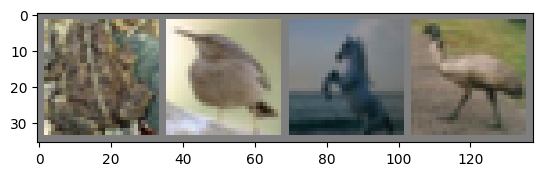

frog  bird  horse bird 


In [8]:
# Numpy function to show images for verification
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(CIFAR10_trainloader_gen)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{CIFAR10_classes[labels[j]]:5s}' for j in range(batch_size)))


In [9]:
class LinearFashionMNIST(nn.Module):
  def __init__(self):
    super(LinearFashionMNIST, self).__init__()

    self.flatten = nn.Flatten()
  
    self.linear_stack = nn.Sequential(
        nn.Linear(28*28, 128),
        nn.Linear(128, 8)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_stack(x)
    return logits


# TODO: add L2 regularization for CIFAR10
# changing kernel size to 2 -- why was it set to 5? 
class CIFAR10Cnn(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5,padding = 'same')
        self.norm1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6,16,5,padding = 'same')
        self.norm2 = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(16,32,5,padding = 'same')
        self.norm3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32,64,5,padding = 'same')
        self.norm4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(64,128,5,padding = 'same')
        self.norm5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128,256,5,padding = 'same')
        self.norm6 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(4096, 10)
        
    def forward(self, x):
        out = F.relu(self.norm1(self.conv1(x)))
        out = F.relu(self.norm2(self.conv2(out)))
        out = self.pool(out)
        out = F.relu(self.norm3(self.conv3(out)))
        out = F.relu(self.norm4(self.conv4(out)))
        out = self.pool(out)
        
        out = F.relu(self.norm5(self.conv5(out)))
        out = F.relu(self.norm6(self.conv6(out)))
        out = self.pool(out)

        out = torch.flatten(out,1)
        out = self.fc1(out)
        return out


In [11]:
#CIFAR10_cnn_test = CIFAR10Cnn(10)
net = CIFAR10Cnn(10)
criterion = nn.CrossEntropyLoss()
CIFAR10_optim = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
for epoch in range(5):
    e_loss = train(CIFAR10_trainloader_gen, net, criterion, CIFAR10_optim, 'cpu')
    print("Epoch", epoch, "loss:", e_loss)

[    1] loss: 0.002
[ 1001] loss: 2.431
[ 2001] loss: 2.005
[ 3001] loss: 1.882
[ 4001] loss: 1.774


KeyboardInterrupt: 

In [ ]:
# Training our base model with 8 classes

for epoch in range(15):
    e_loss = train(no_cat_car_dl, CIFAR10_cnn, criterion, CIFAR10_optim, 'cpu')
    print("Epoch", epoch, "loss:", e_loss)
    
torch.save(CIFAR10_cnn.state_dict(), CIFAR10_model_file)